In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import epsilon_0

import geoana
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

<AxesSubplot: xlabel='x', ylabel='z'>

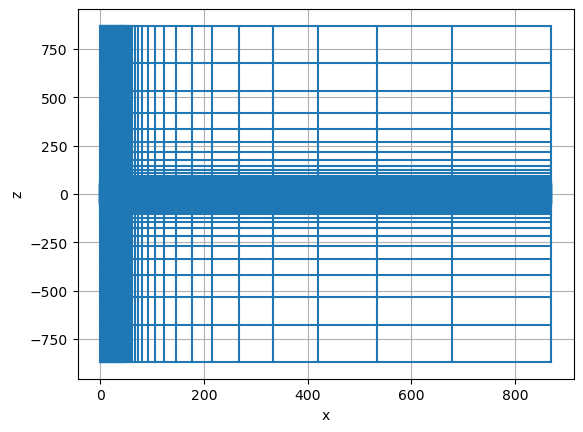

In [2]:
hx = 1
hz = 1
nx = 50
nz = int(2*nx) + 1
npad = 20
pf = 1.3


mesh = discretize.CylindricalMesh(
    [[(hx, nx), (hx, npad, pf)], 1, [(hz, npad, -pf), (hz, nz), (hz, npad, pf)]], 
    x0="00C"
)
mesh.plot_grid()

In [3]:
sigma = 1e-2
conductivity = sigma * np.ones(mesh.n_cells)

epsilon_r = 0
epsilon = epsilon_r * epsilon_0

frequencies = np.r_[100]

print(500/np.sqrt(sigma*frequencies))

[500.]


In [4]:
omega = 2*np.pi*frequencies
print(epsilon * omega**2, sigma*omega)

[0.] [6.28318531]


# Mag Dipole Source

In [5]:
sources = [fdem.sources.MagDipole(
    [], freq, location=np.r_[0, 0, 0]
) for freq in frequencies]

In [6]:
survey = fdem.Survey(sources)

In [7]:
sim = fdem.Simulation3DElectricField(
    mesh, survey=survey, forward_only=True, sigma=conductivity, 
    permittivity=epsilon, solver=Pardiso
)
# sim = fdem.Simulation3DMagneticFluxDensity(
#     mesh, survey=survey, forward_only=True, sigma=conductivity, 
#     permittivity=None, solver=Pardiso
# )

/Users/lindseyjh/git/simpeg/simpeg/SimPEG/electromagnetics/frequency_domain/simulation.py:69: UserWarning: Simulations using permittivity have not yet been thoroughly tested yet, and derivatives are not implemented. Contributions welcome!
  warnings.warn(


In [8]:
fields = sim.fields()

In [9]:
def plot_field_faces(numeric, analytic, ax=None, xlim=np.r_[0, 100], ylim=100*np.r_[-1, 1], name1="numeric", name2="analytic"): 

    if ax is None: 
        fig, ax = plt.subplots(3, 2, figsize=(8, 8))

    for i, f in enumerate([numeric, analytic]):
        if i == 0: 
            name = name1
        elif i == 1:
            name = name2
        elif i == 2: 
            name = "difference" 
            
        for j, component in enumerate(["real", "imag"]):
            plt.colorbar(mesh.plot_image(
                getattr(f, component), view="vec", v_type="F",
                ax=ax[i,j], range_x=xlim, range_y=ylim,
                pcolor_opts={"norm":LogNorm()}
            )[0], ax=ax[i,j])
            

            if i == 1:
                plt.colorbar(mesh.plot_image(
                    getattr(numeric - analytic, component), view="vec", v_type="F",
                    ax=ax[i+1,j], range_x=xlim, range_y=ylim,
                    pcolor_opts={"norm":LogNorm()}
                )[0], ax=ax[i+1,j])
                
            ax[i, j].set_title(f"{name} {component}")

    for a in ax.flatten():
        a.set_xlim(xlim)
        a.set_ylim(ylim)
    
    plt.tight_layout()
        
    return ax

In [10]:
def get_inds(val, x, z):
    if len(val) == mesh.n_faces:
        grid = mesh.faces
    elif len(val) == mesh.n_edges:
        grid = mesh.edges
    
    return (
        (grid[:, 0] > x.min()) &
        (grid[:, 0] < x.max()) & 
        (grid[:, 2] > z.min()) &
        (grid[:, 2] < z.max()) 
    )

In [11]:
def plot_field_edges(numeric, analytic, ax=None, xlim=np.r_[0, 100], ylim=100*np.r_[-1, 1], name1="numeric", name2="analytic"): 
    if ax is None: 
        fig, ax = plt.subplots(3, 2, figsize=(8, 8))
        
    for i, f in enumerate([numeric, analytic]):
        if i == 0: 
            name = name1
        elif i == 1:
            name = name2
        elif i == 2: 
            name = "difference" 
            
        for j, component in enumerate(["real", "imag"]):
            plt.colorbar(mesh.plot_image(
                mesh.average_edge_y_to_cell * f, view=component,
                ax=ax[i,j], range_x=xlim, range_y=ylim,
                # pcolor_opts={"norm":LogNorm()}
            )[0], ax=ax[i,j])

            if i == 1:
                plt.colorbar(mesh.plot_image(
                    mesh.average_edge_y_to_cell * (numeric - analytic), 
                    view=component,
                    ax=ax[i+1,j], range_x=xlim, range_y=ylim,
                    # pcolor_opts={"norm":LogNorm()}
                )[0], ax=ax[i+1,j])
            
            ax[i, j].set_title(f"{name} {component}")

    for a in ax.flatten():
        a.set_xlim(xlim)
        a.set_ylim(ylim)
    plt.tight_layout()

In [12]:
def plot_all_fields_diff(numeric, analytic, x=np.r_[20, 100], z=np.r_[-100, 100], ax=None, name1="numeric", name2="analytic"):
    
    if ax is None: 
        fig, ax = plt.subplots(2, 2, figsize=(8, 4)) 
    
    inds = get_inds(numeric, x, z)

    for j, component in enumerate(["real", "imag"]):
        ax[0, j].semilogy(np.abs(getattr(numeric[inds].squeeze(), component)), ".", label=name1)
        ax[0, j].semilogy(np.abs(getattr(analytic[inds], component)), ".", label=name2)
        ax[0, j].semilogy(np.abs(getattr(analytic[inds], component) - getattr(numeric[inds].squeeze(), component)), ".", label="difference")
        ax[0, j].set_title(component)
        
        ax[1, j].semilogy(getattr(analytic[inds], component) / getattr(numeric[inds].squeeze(), component), ".")
    
    ax[0, 0].legend()
    return ax
    

In [13]:
def print_comparison(numeric, analytic, x=np.r_[50, 100], z=np.r_[-100, 100], name1="numeric", name2="analytic"):
    inds = get_inds(numeric, x, z)
    for component in ["real", "imag"]:
        print(f"{component} {name1:15s} : {np.linalg.norm(np.abs(getattr(numeric[inds], component))):1.4e}")
        print(f"{component} {name2:15s} : {np.linalg.norm(np.abs(getattr(analytic[inds], component))):1.4e}")
        print(f"{component} {'difference':15s} : {np.linalg.norm(np.abs(getattr(analytic[inds], component) - getattr(numeric[inds], component))):1.4e}\n")


In [14]:
analytic_bdipole = geoana.em.fdem.MagneticDipoleWholeSpace(
    sigma=sigma, epsilon=epsilon, frequency=frequencies[0],
    orientation="Z"
)
analytic_mag_b = np.hstack([
    analytic_bdipole.magnetic_flux_density(mesh.faces_x)[:, 0], 
    analytic_bdipole.magnetic_flux_density(mesh.faces_z)[:, 2],
])
analytic_mag_e = analytic_bdipole.electric_field(mesh.edges_y)[:, 1]

analytic_mag_h = np.hstack([
    analytic_bdipole.magnetic_field(mesh.faces_x)[:, 0], 
    analytic_bdipole.magnetic_field(mesh.faces_z)[:, 2],
])
analytic_mag_j = analytic_bdipole.current_density(mesh.edges_y)[:, 1]

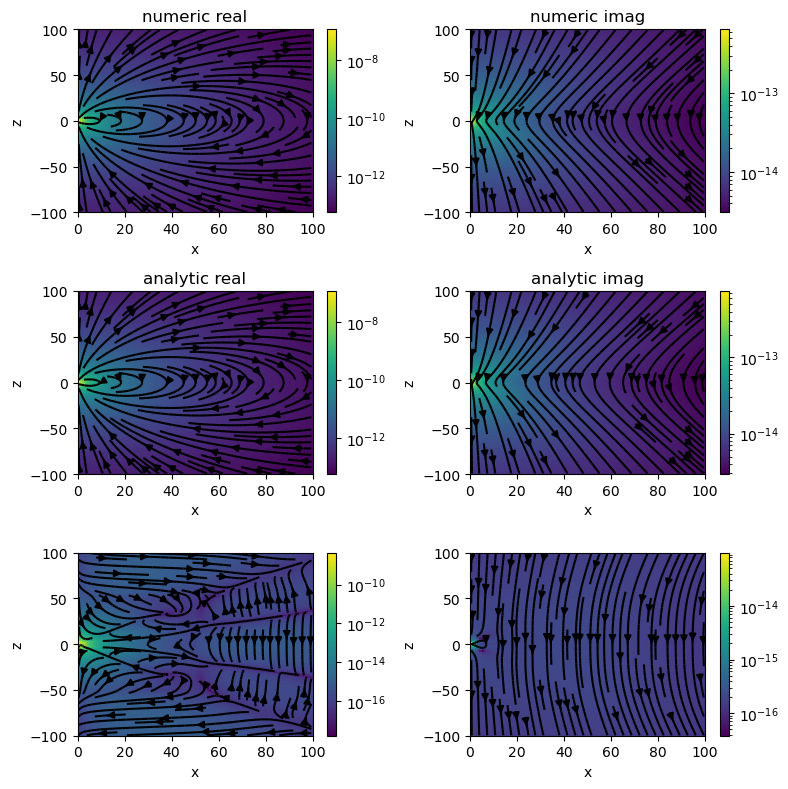

In [15]:
ax = plot_field_faces(fields[:, "b"].squeeze(), analytic_mag_b)

/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_28382/2901456807.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[1, j].semilogy(getattr(analytic[inds], component) / getattr(numeric[inds].squeeze(), component), ".")


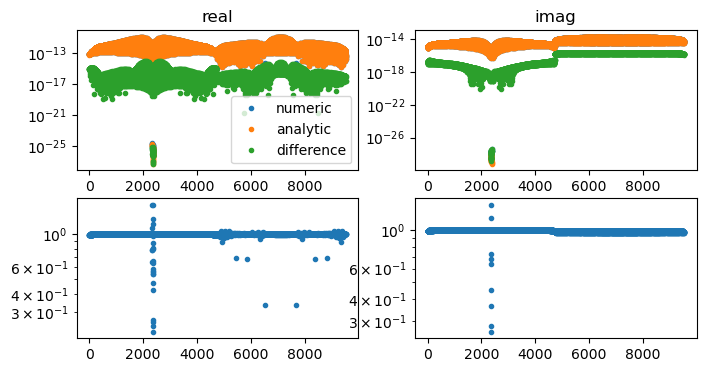

In [16]:
ax = plot_all_fields_diff(fields[:, "b"].squeeze(), analytic_mag_b)

In [17]:
print_comparison(fields[:, "b"].squeeze(), analytic_mag_b)

real numeric         : 1.3493e-11
real analytic        : 1.3490e-11
real difference      : 9.4749e-15

imag numeric         : 2.0965e-13
imag analytic        : 2.0371e-13
imag difference      : 6.2089e-15



/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_28382/2901456807.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[1, j].semilogy(getattr(analytic[inds], component) / getattr(numeric[inds].squeeze(), component), ".")


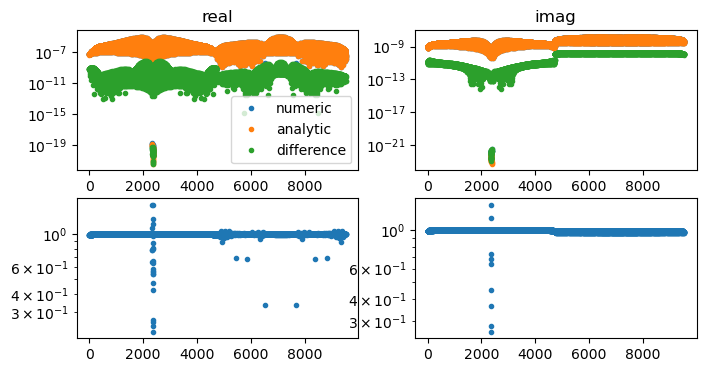

In [18]:
ax = plot_all_fields_diff(fields[:, "h"].squeeze(), analytic_mag_h)

In [19]:
print_comparison(fields[:, "h"].squeeze(), analytic_mag_h)

real numeric         : 1.0738e-05
real analytic        : 1.0735e-05
real difference      : 7.5399e-09

imag numeric         : 1.6684e-07
imag analytic        : 1.6211e-07
imag difference      : 4.9409e-09



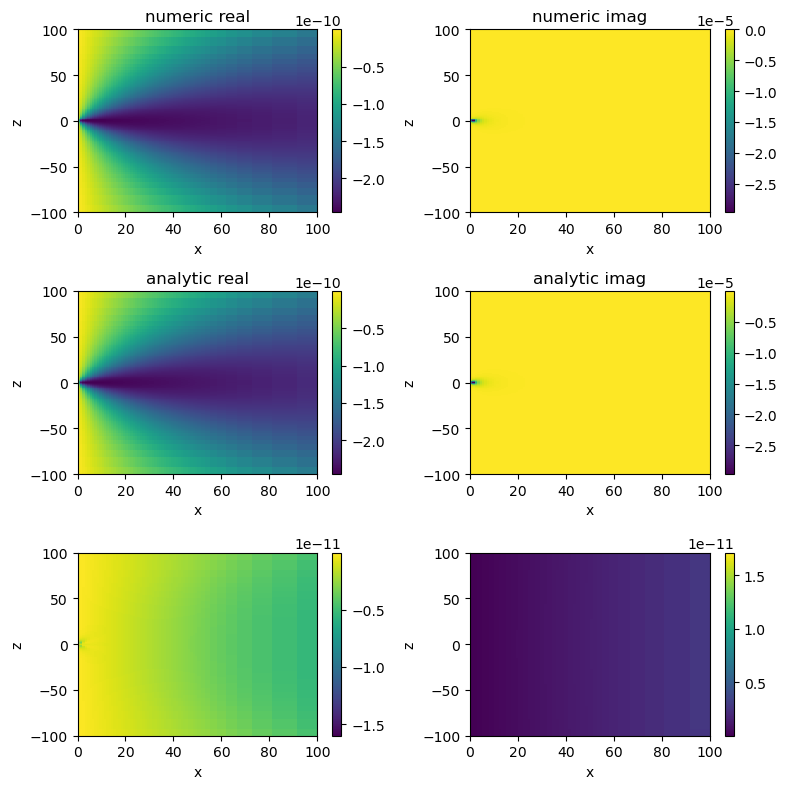

In [20]:
plot_field_edges(fields[:, "e"].squeeze(), analytic_mag_e)

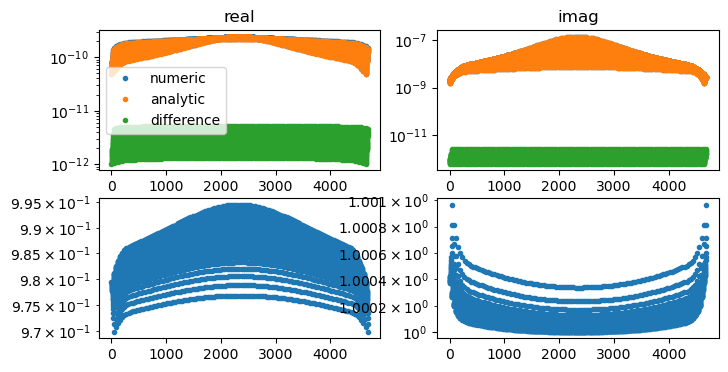

In [21]:
ax = plot_all_fields_diff(fields[:, "e"].squeeze(), analytic_mag_e)

In [22]:
print_comparison(fields[:, "e"].squeeze(), analytic_mag_e)

real numeric         : 6.6707e-09
real analytic        : 6.5420e-09
real difference      : 1.3068e-10

imag numeric         : 4.0378e-07
imag analytic        : 4.0383e-07
imag difference      : 6.1123e-11



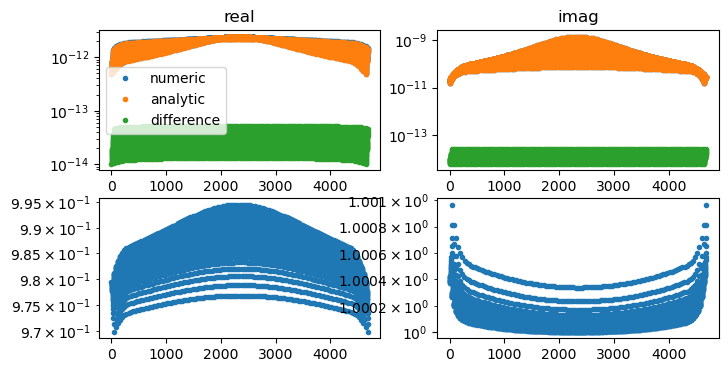

In [23]:
ax = plot_all_fields_diff(fields[:, "j"].squeeze(), analytic_mag_j)

In [24]:
print_comparison(fields[:, "j"].squeeze(), analytic_mag_j)

real numeric         : 6.6707e-11
real analytic        : 6.5420e-11
real difference      : 1.3068e-12

imag numeric         : 4.0378e-09
imag analytic        : 4.0383e-09
imag difference      : 6.1123e-13



# Electric dipole source

In [25]:
epsilon = 800000*epsilon_0
sigma = 1e-2
conductivity = sigma * np.ones(mesh.n_cells)
frequencies = np.r_[100]

omega = 2*np.pi*frequencies
print(epsilon * omega**2, sigma*omega)

[2.79639459] [6.28318531]


In [26]:
500/np.sqrt(frequencies * sigma)

array([500.])

In [27]:
sources_j = [fdem.sources.LineCurrent(
    [], freq, location=np.array([[0, 0, 1], [0, 0, -1]]), current=1/2
) for freq in frequencies]

In [28]:
survey_j = fdem.Survey(sources_j)

In [29]:
# sim_j = fdem.Simulation3DCurrentDensity(
#     mesh, survey=survey_j, forward_only=True, sigma=conductivity, 
#     permittivity=epsilon, solver=Pardiso
# )
sim_j = fdem.Simulation3DMagneticField(
    mesh, survey=survey_j, forward_only=True, sigma=conductivity, 
    permittivity=epsilon, solver=Pardiso
)

In [30]:
sj = sources_j[0]
mesh.faces[sj.s_e(sim_j).nonzero()]

array([[ 0.5,  0. , -0.5],
       [ 0.5,  0. ,  0.5]])

In [31]:
fields_j = sim_j.fields()

In [32]:
analytic_edipole = geoana.em.fdem.ElectricDipoleWholeSpace(
    sigma=sigma, epsilon=epsilon, frequency=frequencies[0],
    orientation="Z"
)

analytic_j = np.hstack([
    analytic_edipole.current_density(mesh.faces_x)[:, 0], 
    analytic_edipole.current_density(mesh.faces_z)[:, 2],
])
analytic_h = analytic_edipole.magnetic_field(mesh.edges_y)[:, 1]

analytic_e = np.hstack([
    analytic_edipole.electric_field(mesh.faces_x)[:, 0], 
    analytic_edipole.electric_field(mesh.faces_z)[:, 2],
])
analytic_b = analytic_edipole.magnetic_flux_density(mesh.edges_y)[:, 1]

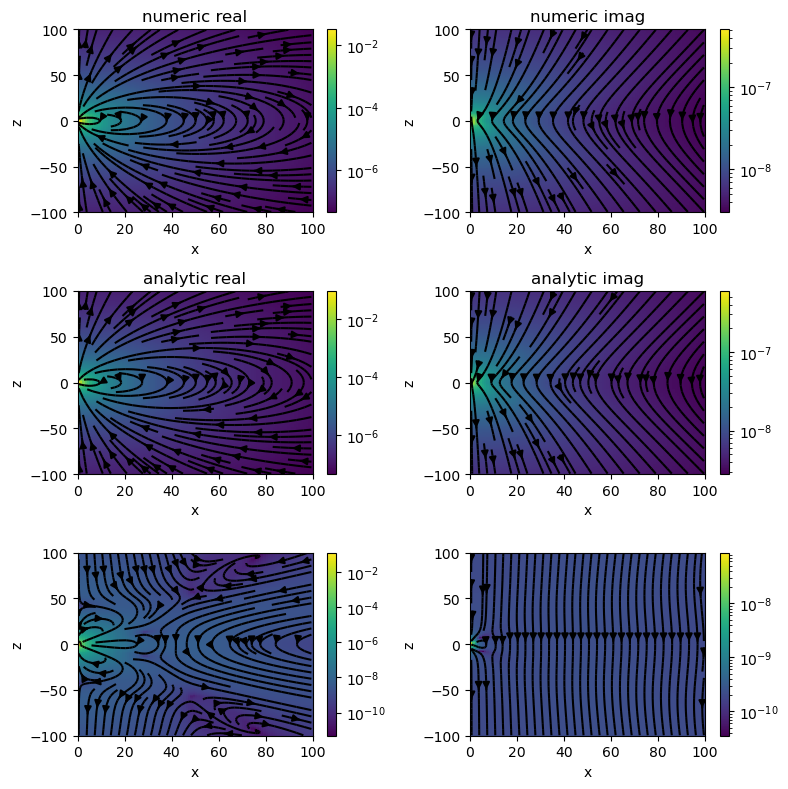

In [33]:
ax = plot_field_faces(fields_j[:, "j"].squeeze(), analytic_j)

/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_28382/2901456807.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[1, j].semilogy(getattr(analytic[inds], component) / getattr(numeric[inds].squeeze(), component), ".")


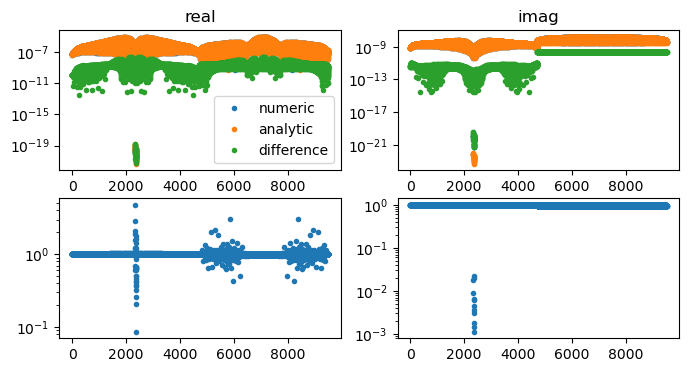

In [34]:
ax = plot_all_fields_diff(fields_j[:, "j"].squeeze(), analytic_j)

In [35]:
print_comparison(fields_j[:, "j"].squeeze(), analytic_j)

real numeric         : 1.0738e-05
real analytic        : 1.0727e-05
real difference      : 9.5040e-08

imag numeric         : 1.8602e-07
imag analytic        : 1.7881e-07
imag difference      : 7.6265e-09



/var/folders/lw/k5tlwhn57h96_sbv8smj_3dc0000gn/T/ipykernel_28382/2901456807.py:14: RuntimeWarning: divide by zero encountered in divide
  ax[1, j].semilogy(getattr(analytic[inds], component) / getattr(numeric[inds].squeeze(), component), ".")


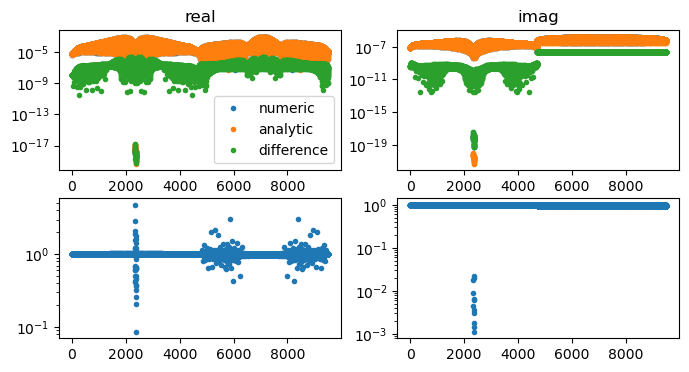

In [36]:
ax = plot_all_fields_diff(fields_j[:, "e"].squeeze(), analytic_e)

In [37]:
print_comparison(fields_j[:, "e"].squeeze(), analytic_e)

real numeric         : 1.0738e-03
real analytic        : 1.0727e-03
real difference      : 9.5040e-06

imag numeric         : 1.8602e-05
imag analytic        : 1.7881e-05
imag difference      : 7.6265e-07



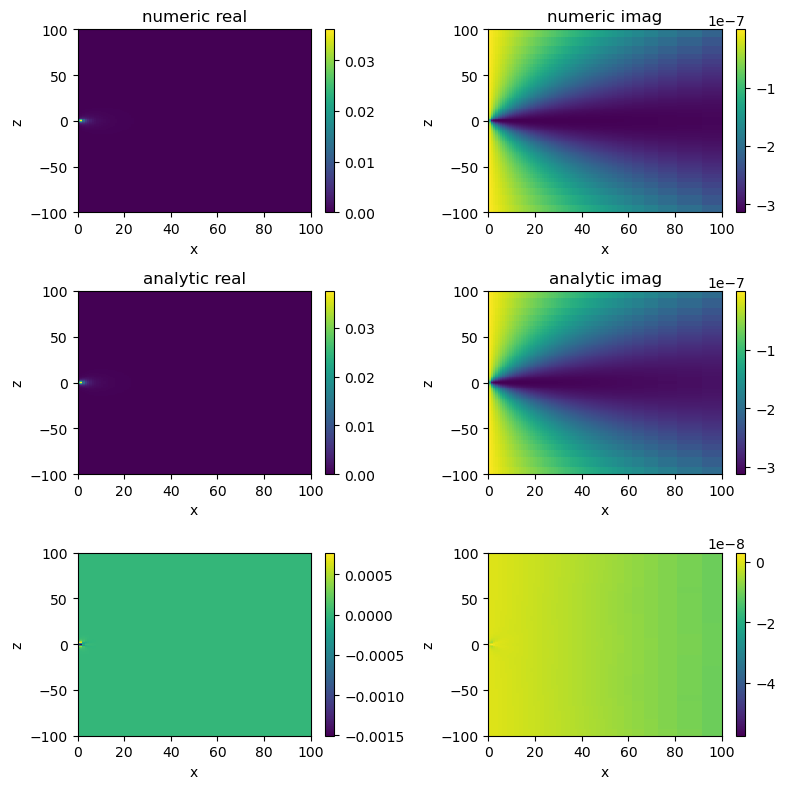

In [38]:
ax=plot_field_edges(fields_j[:, "h"].squeeze(), analytic_h)

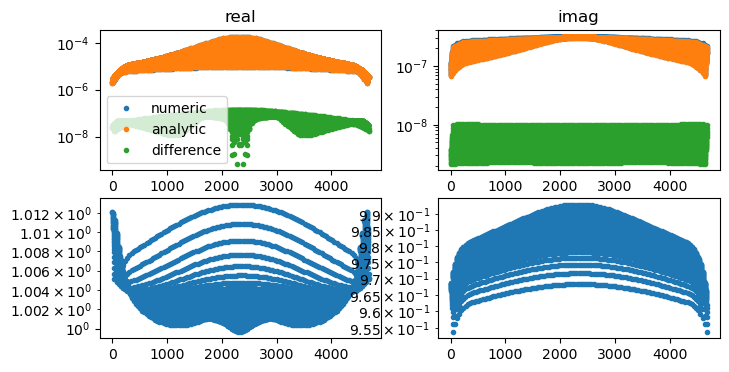

In [39]:
ax = plot_all_fields_diff(fields_j[:, "h"].squeeze(), analytic_h)

In [40]:
print_comparison(fields_j[:, "h"].squeeze(), analytic_h)

real numeric         : 5.1217e-04
real analytic        : 5.1480e-04
real difference      : 2.8108e-06

imag numeric         : 9.1048e-06
imag analytic        : 8.8656e-06
imag difference      : 2.4415e-07



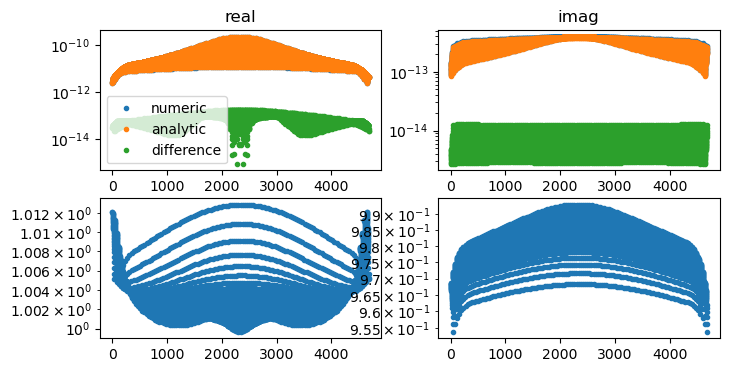

In [41]:
ax = plot_all_fields_diff(fields_j[:, "b"].squeeze(), analytic_b)

In [42]:
print_comparison(fields_j[:, "b"].squeeze(), analytic_b)

real numeric         : 6.4361e-10
real analytic        : 6.4691e-10
real difference      : 3.5321e-12

imag numeric         : 1.1441e-11
imag analytic        : 1.1141e-11
imag difference      : 3.0681e-13



# test a scenario with contrasts in permittivity 

In [43]:
sigma_back = 1e-2
rel_permittivity_back = 1
rel_permittiyity_target = 1e6

target_z = np.r_[-20, -40]
target_x = np.r_[0, 60]

In [44]:
sigma = np.ones(mesh.n_cells) * sigma_back
epsilon_r = np.ones(mesh.n_cells) * rel_permittivity_back

target_inds = (
    (mesh.cell_centers[:, 0] >= target_x.min()) &
    (mesh.cell_centers[:, 0] <= target_x.max()) &
    (mesh.cell_centers[:, 2] >= target_z.min()) &
    (mesh.cell_centers[:, 2] <= target_z.max()) 
)

epsilon_r[target_inds] = rel_permittiyity_target

(-200.0, 200.0)

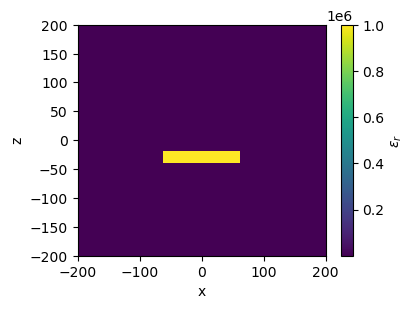

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

xlim = 200*np.r_[-1, 1]
zlim = 200*np.r_[-1,1]

cb = plt.colorbar(mesh.plot_image(epsilon_r, mirror=True, ax=ax)[0], ax=ax)
cb.set_label("$\epsilon_r$")
ax.set_xlim(xlim)
ax.set_ylim(zlim)

In [46]:
sources_j_target = [fdem.sources.LineCurrent(
    [], freq, location=np.array([[0, 0, 1], [0, 0, -1]]), current=1/2
) for freq in frequencies]

In [47]:
survey_j_target = fdem.Survey(sources_j_target)

In [48]:
sim_j_target = fdem.Simulation3DCurrentDensity(
    mesh, survey=survey_j_target, forward_only=True, sigma=sigma, 
    permittivity=epsilon_r * epsilon_0, solver=Pardiso
)

In [49]:
sources_h_target = [fdem.sources.LineCurrent(
    [], freq, location=np.array([[0, 0, 1], [0, 0, -1]]), current=1/2
) for freq in frequencies]

In [50]:
survey_h_target = fdem.Survey(sources_h_target)

In [51]:
sim_h_target = fdem.Simulation3DMagneticField(
    mesh, survey=survey_h_target, forward_only=True, sigma=sigma, 
    permittivity=epsilon_r * epsilon_0, solver=Pardiso
)

In [52]:
fields_j_target = sim_j_target.fields()
fields_h_target = sim_h_target.fields()

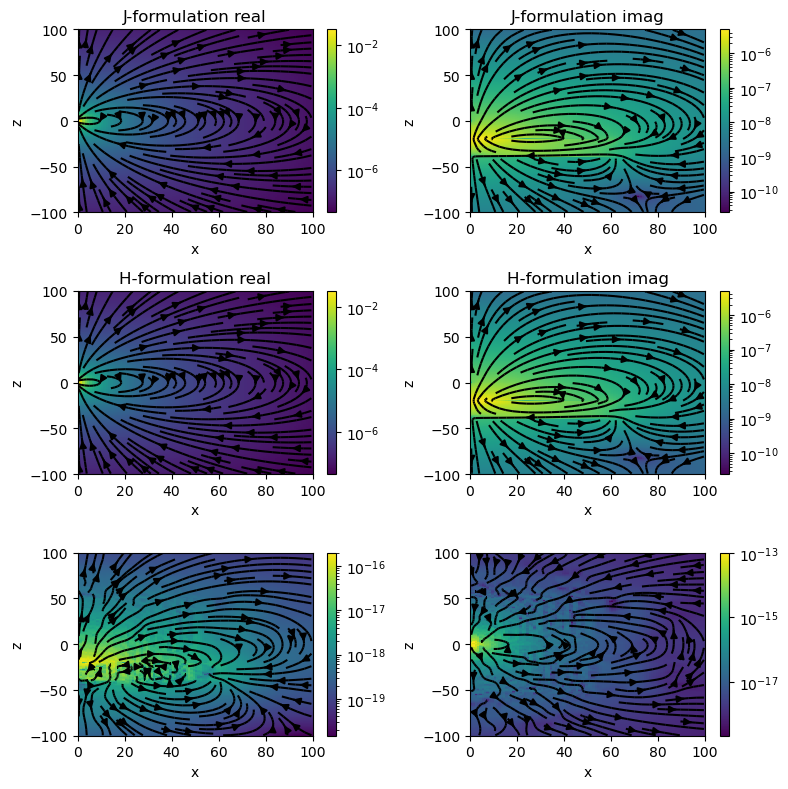

In [53]:
ax = plot_field_faces(fields_j_target[:, "j"].squeeze(), fields_h_target[:, "j"].squeeze(), name1="J-formulation", name2="H-formulation")

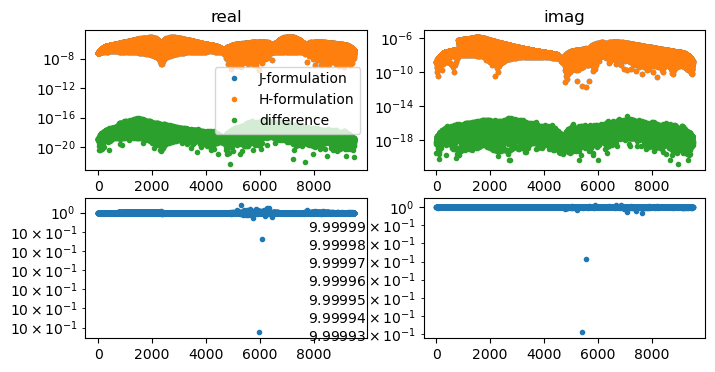

In [54]:
ax = plot_all_fields_diff(fields_j_target[:, "j"].squeeze(), fields_h_target[:, "j"].squeeze(), name1="J-formulation", name2="H-formulation")

In [55]:
print_comparison(fields_j_target[:, "j"].squeeze(), fields_h_target[:, "j"].squeeze(), name1="J-formulation", name2="H-formulation")

real J-formulation   : 1.1018e-05
real H-formulation   : 1.1018e-05
real difference      : 7.7977e-17

imag J-formulation   : 2.1940e-06
imag H-formulation   : 2.1940e-06
imag difference      : 2.5015e-16



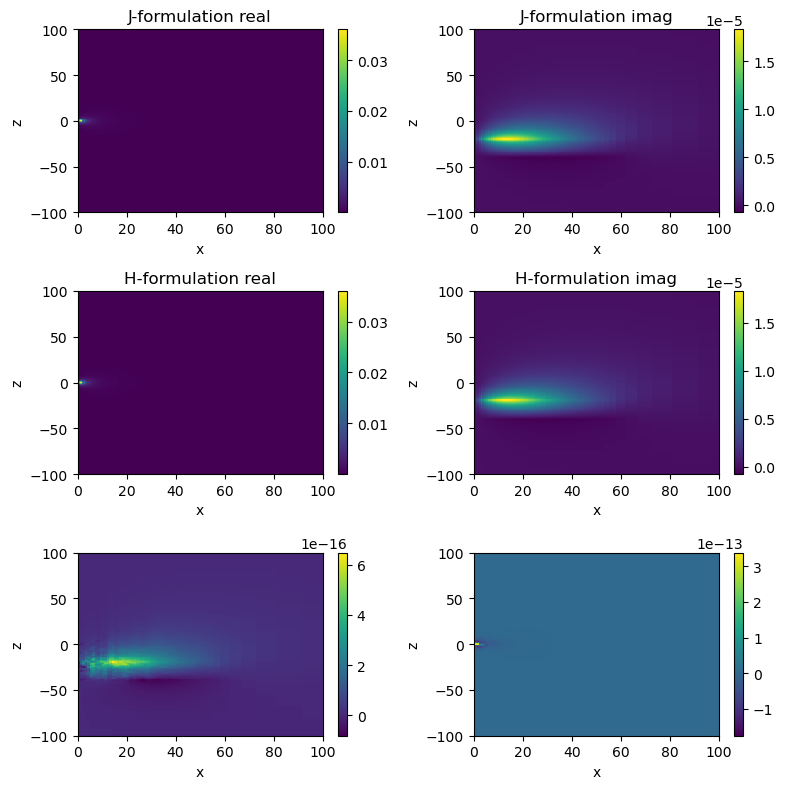

In [56]:
ax = plot_field_edges(fields_j_target[:, "h"].squeeze(), fields_h_target[:, "h"].squeeze(), name1="J-formulation", name2="H-formulation")

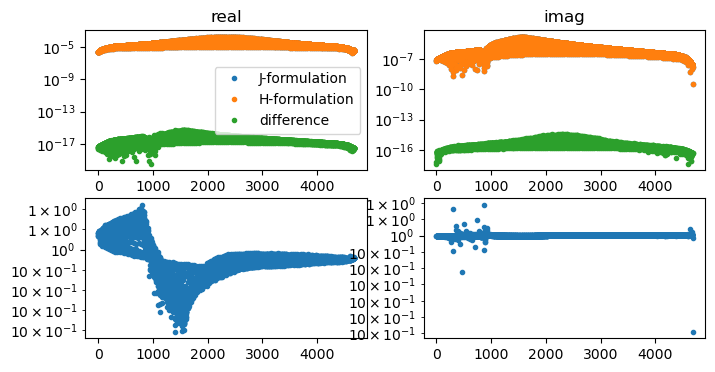

In [57]:
ax = plot_all_fields_diff(fields_j_target[:, "h"].squeeze(), fields_h_target[:, "h"].squeeze(), name1="J-formulation", name2="H-formulation")

In [58]:
print_comparison(fields_j_target[:, "h"].squeeze(), fields_h_target[:, "h"].squeeze(), name1="J-formulation", name2="H-formulation")

real J-formulation   : 5.2331e-04
real H-formulation   : 5.2331e-04
real difference      : 1.1203e-15

imag J-formulation   : 3.2529e-05
imag H-formulation   : 3.2529e-05
imag difference      : 8.2633e-15

